In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d "suchintikasarkar/sentiment-analysis-for-mental-health"

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health
License(s): DbCL-1.0
sentiment-analysis-for-mental-health.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile

dataset_zip = zipfile.ZipFile("/content/sentiment-analysis-for-mental-health.zip", "r")
dataset_zip.extractall()
dataset_zip.close()

In [1]:
import pandas as pd
raw_data = pd.read_csv("/content/Combined Data.csv")

In [2]:
df = raw_data.dropna()
print(len(df))
df.sample(frac = 1).head()

52681


,Unnamed: 0,statement,status
19404,19404,why is everything so difficult? I cannot get a...,Depression
3826,3826,"hhh because lucas is really bucin sm wayv :""""",Normal
1613,1613,morning ol,Normal
3094,3094,"I'm not scared, but in the past I dreamed of a...",Normal
21248,21248,I have been playing metal gear solid for about...,Depression


In [3]:
classes = df['status'].unique()
print(len(classes))
classes

7


array(['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar',
       'Personality disorder'], dtype=object)

In [4]:
# Remove imbalanced label data

df = df[~df['status'].isin(("Anxiety", "Bipolar", "Stress", "Personality disorder"))]
df['status'].value_counts()

,count
status,
Normal,16343
Depression,15404
Suicidal,10652


In [5]:
classes = df['status'].unique()
print("Total classes/ labels:", len(classes), "\n")
classes

Total classes/ labels: 3 



array(['Normal', 'Depression', 'Suicidal'], dtype=object)

In [26]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df["status_encode"] = label_encoder.fit_transform(df["status"])

classes_pd = pd.DataFrame({
    "Class Name" : label_encoder.transform(label_encoder.classes_),
    "Value" : label_encoder.classes_
})

classes = label_encoder.classes_
display(classes_pd)

,Class Name,Value
0,0,Depression
1,1,Normal
2,2,Suicidal


In [31]:
# train-test-split

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    df['statement'].values, df['status_encode'].values,
    test_size=0.20,
    random_state=42,
)
print(len(x_train), len(y_train), len(x_test), len(y_test))

33919 33919 8480 8480


In [32]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(oov_token='UNK', lower = True)
tokenizer.fit_on_texts(x_train)

x_train_tokenized = tokenizer.texts_to_sequences(x_train)
x_test_tokenized = tokenizer.texts_to_sequences(x_test)

In [33]:
max_len = max([len(x) for x in x_train_tokenized])
print(max_len)

6300


In [34]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train_tokenized_padded = pad_sequences(x_train_tokenized, maxlen = max_len, padding='post', truncating='post')
x_test_tokenized_padded = pad_sequences(x_test_tokenized, maxlen = max_len, padding='post', truncating='post')

In [35]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

48369

In [40]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adagrad

tf.keras.backend.clear_session()

num_lstm = 1
num_hidden = 32
embedding_size = 128

# Define the model using Sequential
model = Sequential([
    # Sequences length
    layers.Input(shape=(max_len,)),

    # Embedding layer
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_size, mask_zero=True),

    # Bidirectional LSTM layer
    layers.Bidirectional(layers.LSTM(num_hidden, return_sequences=True)),

    # Flatten the output to match the linear layer input
    layers.Flatten(),

    # layers.TimeDistributed(layers.Flatten()),
    # layers.GlobalAveragePooling1D(),

    # Dropout layer
    layers.Dropout(0.3),

    # Dense layer with 3 output units
    layers.Dense(len(classes), activation='softmax')
])

# Compile the model
model.compile(optimizer=Adagrad(learning_rate=1e-2, weight_decay=1e-4),
              loss="sparse_categorical_crossentropy",  # Assuming logits output from_logits=True
              metrics=['accuracy'],
)
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#  Build the model
model.build(input_shape=(None, max_len))

# View model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 6300, 128)           │       6,191,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 6300, 64)            │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 403200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 403200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │       1,209,603 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,442,051 (28.39 MB)

 Trainable params: 7,442,051 (28.39 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
test = x_train_tokenized_padded[0]
test = tf.convert_to_tensor(test[None, :], dtype=tf.int32)
print(test.shape)
pred = model(test)
print(pred.shape)

(1, 6300)
(1, 3)


In [42]:
num_epochs = 16
num_batch = 24

# Train the model using `model.fit`
history = model.fit(
    x_train_tokenized_padded, y_train,
    batch_size=num_batch, epochs=num_epochs,
    validation_split=0.2,
    verbose=1
)

Epoch 1/16
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 76s 65ms/step - accuracy: 0.6299 - loss: 0.8765 - val_accuracy: 0.6632 - val_loss: 0.7496
Epoch 2/16
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 79s 63ms/step - accuracy: 0.6464 - loss: 0.7485 - val_accuracy: 0.6934 - val_loss: 0.6505
Epoch 3/16
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 81s 62ms/step - accuracy: 0.7041 - loss: 0.6321 - val_accuracy: 0.7416 - val_loss: 0.5479
Epoch 4/16
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 108s 85ms/step - accuracy: 0.7671 - loss: 0.5165 - val_accuracy: 0.7811 - val_loss: 0.4782
Epoch 5/16
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 74s 65ms/step - accuracy: 0.8007 - loss: 0.4518 - val_accuracy: 0.8016 - val_loss: 0.4456
Epoch 6/16
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 80s 63ms/step - accuracy: 0.8236 - loss: 0.4083 - val_accuracy: 0.7978 - val_loss: 0.4521
Epoch 7/16
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 82s 64ms/step - accuracy: 0.8393 - loss: 0.3684 - val_accuracy: 0.8062 - val_loss: 0.4281
Epoch 8/16
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 81s 63ms/step - accuracy: 0.8519 

In [43]:
# Access training history
train_loss = history.history['loss']
train_acc = history.history['accuracy']

# Print final training statistics
print('Final Train Loss:', train_loss[-1])
print('Final Train Acc:', train_acc[-1])

Final Train Loss: 0.24962446093559265
Final Train Acc: 0.8951169848442078


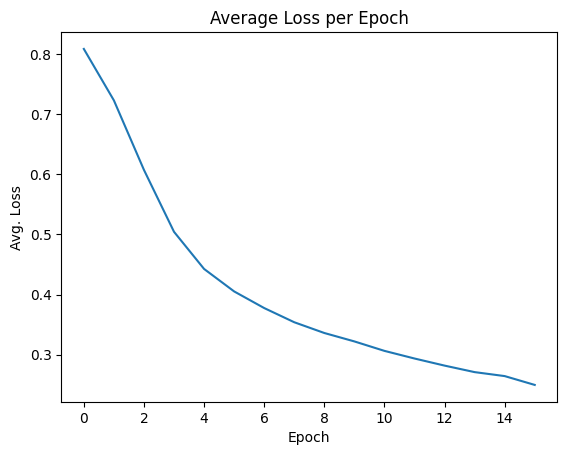

In [44]:
from matplotlib import pyplot as plt

plt.plot(train_loss)
plt.title('Average Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Avg. Loss')
plt.show()

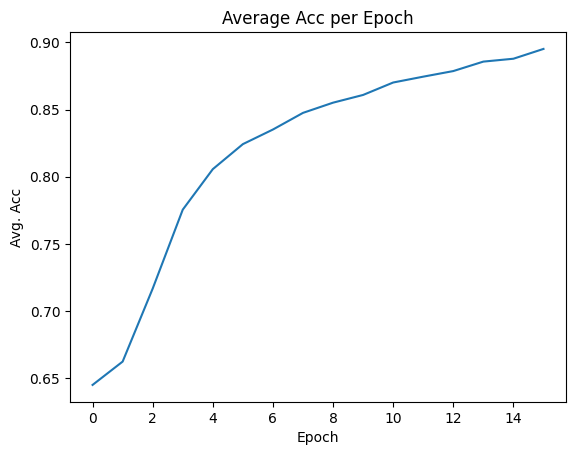

In [45]:
from matplotlib import pyplot as plt

plt.plot(train_acc)
plt.title('Average Acc per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Avg. Acc')
plt.show()

In [46]:
test_loss, test_acc = model.evaluate(x_test_tokenized_padded, y_test, batch_size=32, verbose=1)
print(f"Test Loss    : {test_loss}")
print(f"Test Accuracy: {test_acc}")

265/265 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.8236 - loss: 0.4797
Test Loss    : 0.4782957434654236
Test Accuracy: 0.8216981291770935


In [47]:
import numpy as np

y_pred = model.predict(x_test_tokenized_padded)
y_pred = np.argmax(y_pred, axis=1)

  1/265 ━━━━━━━━━━━━━━━━━━━━ 1:03 239ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'flatten' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


265/265 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step


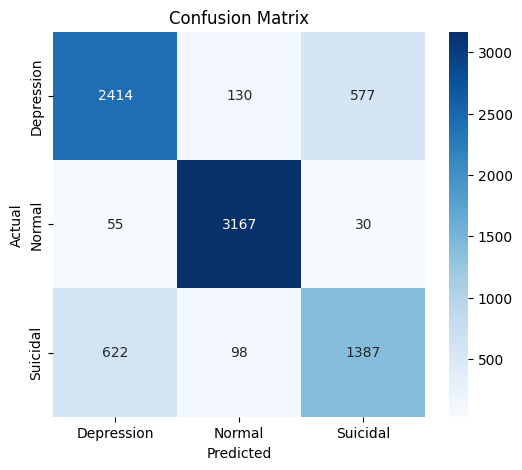

In [48]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

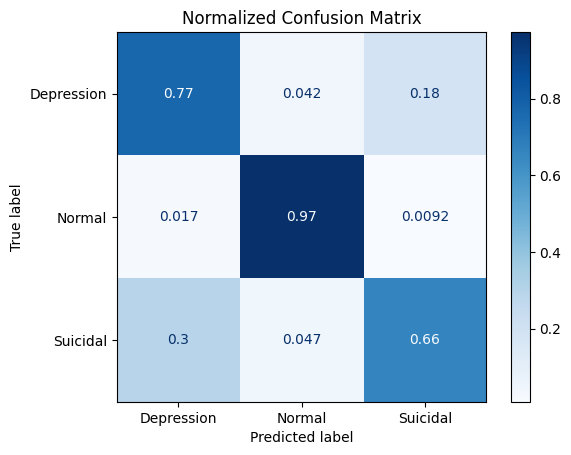

In [49]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=classes, cmap="Blues", normalize="true")
plt.title("Normalized Confusion Matrix")
plt.show()

In [50]:
from sklearn import metrics
pd.DataFrame(metrics.classification_report(y_test, y_pred, target_names = classes, output_dict=True))

,Depression,Normal,Suicidal,accuracy,macro avg,weighted avg
precision,0.780977,0.932842,0.695587,0.821698,0.803135,0.817999
recall,0.773470,0.973862,0.658282,0.821698,0.801871,0.821698
f1-score,0.777205,0.952911,0.676420,0.821698,0.802179,0.819545
support,3121.000000,3252.000000,2107.000000,0.821698,8480.000000,8480.000000


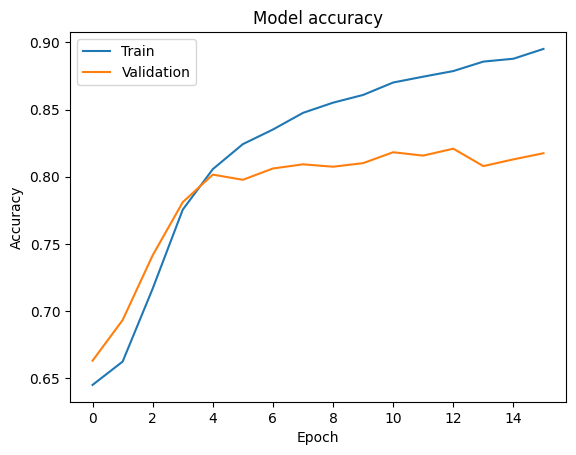

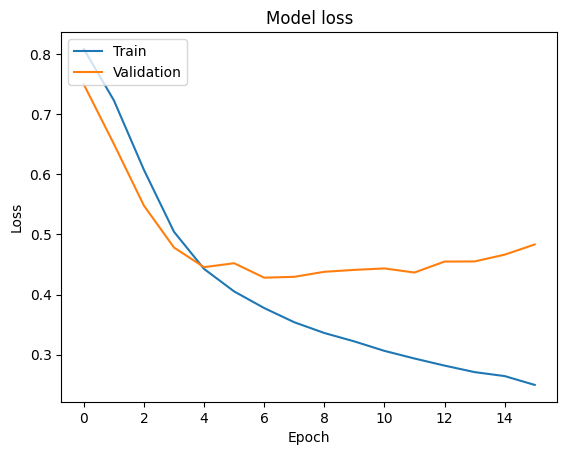

In [51]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Save entire model

PATH = '/content/sentiment_analysis_model.h5'
model.save(PATH)

In [ ]:
# Save configuration file

import json

# Create a dictionary to store all the variables
data = {
    'classes': classes.tolist(),
    'max_len': max_len,
    'vocab_size': vocab_size,
    'tokenizer': tokenizer.to_json()
}

# Save the dictionary to a pickle file
with open('config.json', 'w') as f:
    json.dump(data, f)

In [64]:
def predict_sentiment(sentiment) :
  sentiment_tokenized = tokenizer.texts_to_sequences([sentiment])
  sentiment_tokenized_padded = pad_sequences(sentiment_tokenized, maxlen = max_len, padding='post', truncating='post')
  prediction = model.predict(sentiment_tokenized_padded)
  pred_prob = prediction.max()
  pred_class = classes[np.argmax(prediction, axis=1)[0]]
  return pred_class, pred_prob

In [70]:
predict_sentiment(input("What's your matter?\n"))

What's your matter?
ha
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


('Normal', 0.7028248)